<a href="https://colab.research.google.com/github/Folskyy/lamia/blob/main/emotions_recognition/Detector_de_emo%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação de bibliotecas

In [23]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import tensorflow
from google.colab.patches import cv2_imshow
from google.colab import drive

# Acessando arquivos do drive

Montagem do Drive

In [24]:
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


 Extração do zip contido no Drive para o diretório atual da máquina

In [25]:
path = '/content/gdrive/MyDrive/Colab Notebooks/emotions_rocognition/Material.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')

Extração da base de dados contida dentro do arquivo extraído anteriormente

In [26]:
base_imgs = '/content/Material/fer2013.zip'
zip_object = zipfile.ZipFile(file=base_imgs, mode='r')
zip_object.extractall('./')
zip_object.close

<bound method ZipFile.close of <zipfile.ZipFile filename='/content/Material/fer2013.zip' mode='r'>>

# Acessando a base de imagens de expressões faciais FER2013

35.887 imagens, 48x48px cada imagem, rotuladas com 7 emoções.  
O arquivo fer2013.csv tem as colunas emotion, pixels (sequência de pixels de uma imagem em tons de cinza) e Usage (separa os dados em treino/teste)

In [27]:
data = pd.read_csv('/content/fer2013/fer2013.csv')
print(data.head)

<bound method NDFrame.head of        emotion                                             pixels        Usage
0            0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...     Training
1            0  151 150 147 155 148 133 111 140 170 174 182 15...     Training
2            2  231 212 156 164 174 138 161 173 182 200 106 38...     Training
3            4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...     Training
4            6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...     Training
...        ...                                                ...          ...
35882        6  50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...  PrivateTest
35883        3  178 174 172 173 181 188 191 194 196 199 200 20...  PrivateTest
35884        0  17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...  PrivateTest
35885        3  30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...  PrivateTest
35886        2  19 13 14 12 13 16 21 33 50 57 71 84 97 108 122...  PrivateTest

[35887 rows x 3 colum

Gráfico com a contagem de ocorrências de cada emoção

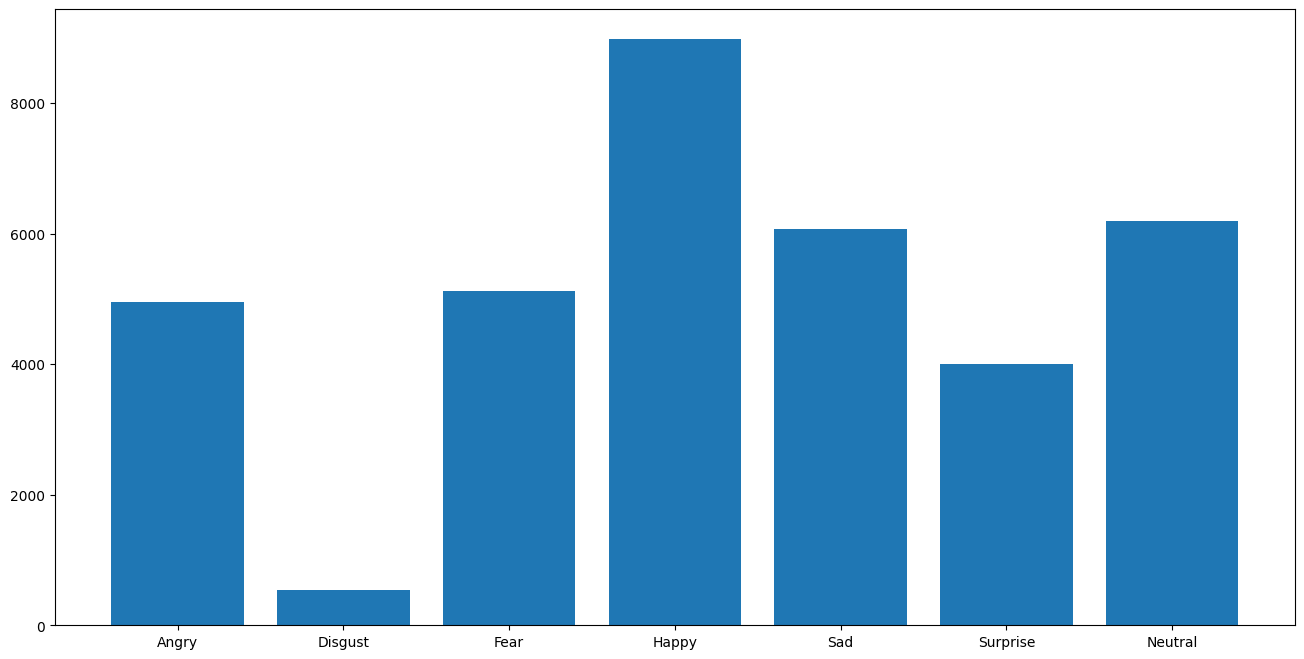

In [28]:
categorical_emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

emotions_count = data.groupby('emotion')['pixels'].count()

plt.figure(figsize=(16, 8))
plt.bar(categorical_emotions, emotions_count)
plt.show()

# Pré-processamento

Leitura e redimensionamento das sequencias de pixels para montar a imagem

In [29]:
pixels = data['pixels'].tolist() # recebe uma lista de strings com os pixels
h, w = 48, 48 # dimensões da imagem
images = []

for pixel_sequence  in pixels: # itera em cada string de pixels
  # separa todos os valores na string e converte para inteiros
  image = [int(pixel) for pixel in pixel_sequence.split(' ')]
  # converte a lista de pixels(int) em uma np.array redimensionada
  image = np.array(image).reshape(h, w)
  images.append(image)

# lista para np.array
images = np.array(images)
images.shape

(35887, 48, 48)

0


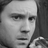

1


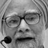

2


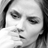

3


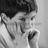

4


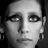

[(None, None), (None, None), (None, None), (None, None), (None, None)]

In [30]:
[(print(i), cv2_imshow(images[i])) for i in range(5)]

Normalização dos valores dos pixels

In [31]:
images = images.astype('float32')
images = images / 255

Conversão de variáveis categóricas em colunas numéricas.

In [32]:
emotions = pd.get_dummies(data['emotion']).values
# emotions = pd.get_dummies(categorical_emotions).values

# Importação do TensorFlow/Keras

importação das estruturas necessárias para arquitetar a CNN

In [33]:
from sklearn.model_selection import train_test_split # precisa?
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
# ajuda a evitar o overfitting
from tensorflow.keras.regularizers import l2
# Redução dinâmica do LR quando uma métrica monitorada para de molhorar
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Interrompe o treinamento quando uma métrica para de melhorar
from tensorflow.keras.callbacks import EarlyStopping
# Salva o modelo em um determinado ponto do treinamento como checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
# salvar e carregar modelo
from tensorflow.keras.models import load_model, model_from_json

# Divisão dos dados (treinamento x teste)

Divisão dos dados: (imagem_para_treino, imagem_para_teste, rotulo_do_treino, rotulo_do_teste)

In [49]:
# o random state permite obter essa mesma distribuição caso divida novamente
x_train_val, x_test, y_train_val, y_test = train_test_split(images, emotions,test_size=0.1,
                                                            random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val,test_size=0.2,
                                                  random_state=42)

In [50]:
print(f"Número de imagens para treinamento: {len(x_train)}")
print(f"Número de imagens para Validação:   {len(x_val)}")
print(f"Número de imagens para testes:      {len(x_test)}")

Número de imagens para treinamento: 25838
Número de imagens para Validação:   6460
Número de imagens para testes:      3589


Salvamento dos dados de teste em formato de arquivo para facilitar a construção da matriz de confusão.

In [53]:
np.save('mod_xtest', x_test)
np.save('mod_ytest', y_test)

# Arquitetura do modelo

definição de valores para os principais parâmetros exigidos

In [35]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100

Arquitetura sequencial do modelo

In [36]:
model = Sequential()

# CAMADA DE ENTRADA
# data_format: ordem das dimensões do input. 'channels_last' é o padrão
model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu',
                 input_shape=(w, h, 1), data_format='channels_last',
                 kernel_regularizer=l2(0.01)))
# CONV-POOL 1
model.add(Conv2D(num_features, kernel_size=(3,3), activation='relu',
                 padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))

# CONV-POOL 2
model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu',
                 padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3,3), activation='relu',
                 padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(Dropout(0.2))


# CONV-POOL 3
model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu',
                 padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3,3), activation='relu',
                 padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(Dropout(0.2))

# CONV-POOL 4
model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu',
                 padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3,3), activation='relu',
                 padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
model.add(Dropout(0.2))

# PLANIFICAÇÃO
model.add(Flatten())

# CAMADA DENSA 1
model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.2))

# CAMADA DENSA 2
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.2))

# CAMADA DENSA 3
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.2))

# CAMADA DE SAÍDA
# softmax para classificação multiclasse
model.add(Dense(num_labels, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 conv2d_9 (Conv2D)           (None, 46, 46, 64)        36928     
                                                                 
 batch_normalization_7 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 23, 23, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 23, 23, 128)      

# Compilando o modelo

Configura o modelo

In [37]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001,beta_1=0.9, beta_2=0.99, epsilon=1e-7),
              metrics=['accuracy'])

Variáveis para salvar os pesos e a estrutura do modelo no drive

In [38]:
model_file_weight = '/content/gdrive/MyDrive/Colab Notebooks/emotions_rocognition/model_file_weight.h5'
model_file_struct = '/content/gdrive/MyDrive/Colab Notebooks/emotions_rocognition/model_file_struct.json'

Callbacks

In [39]:
# verbose: ativa as notificações
# patience: número tolerável de batches sem aumentar a precisão
# monitor: métrica a ser monitorada
checkpointer = ModelCheckpoint(model_file_weight, monitor='val_loss', verbose=1,
                               save_best_only=True)
# factor: novo_LR = atual_LR * factor (reduz em 10%)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3,
                               verbose=1)
# min_delta: Valor mínimo de variação na métrica para ser considerada uma melhoria.
# mode: Indica se o treinamento deve parar quando a métrica aumentar ou diminuir.
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=8,
                              verbose=1, mode='auto')

Salvar o modelo como um arquivo JSON

In [40]:
model_json = model.to_json()
with open(model_file_struct, 'w') as f:
  f.write(model_json)

# Treinamento

In [41]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    shuffle=True,
                    callbacks=[lr_reducer, checkpointer, early_stopper])

Epoch 1/100
 16/404 [>.............................] - ETA: 27:16 - loss: 2.4900 - accuracy: 0.1875

KeyboardInterrupt: 

# Continuar treinamento

In [ ]:
model = load_model(model_file_weight)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_val, y_val),
                    shuffle=True,
                    callbacks=[lr_reducer, checkpointer, early_stopper])

Salva o modelo completo (arquitetura e os pesos)

In [ ]:
model.save('/content/gdrive/MyDrive/Colab Notebooks/emotions_rocognition/model_file.h5')

# Carregar modelo salvo

In [107]:
model_w_weight = '/content/gdrive/MyDrive/Colab Notebooks/emotions_rocognition/model_file.h5'
loaded_model = load_model(model_w_weight)

# Gráfico do accuracy ao longo do treinamento

In [105]:
def acc_graph(model_history):
  fig, axis = plt.subplots(1, 2, figsize=(15, 5))
  axis[0].plot(range(1, len(model_history.history['accuracy']) + 1),
               model_history.history['accuracy'], 'r')
  axis[0].plot(range(1, len(model_history.history['val_accuracy']) + 1),
               model_history.history['val_accuracy'], 'b')
  axis[0].set_title('Model Accuracy')
  axis[0].set_ylabel('Accuracy')
  axis[0].set_xlabel('Epoch')
  axis[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1),
                     len(model_history.history['accuracy']) // 10)
  axis[0].legend(['training accuracy', 'validation_acc'], loc='best')

  axis[1].plot(range(1, len(model_history.history['loss']) + 1),
               model_history.history['loss'], 'r')
  axis[1].plot(range(1, len(model_history.history['val_loss']) + 1),
               model_history.history['val_loss'], 'b')
  axis[1].set_title('Model Loss')
  axis[1].set_ylabel('Loss')
  axis[1].set_xlabel('Epoch')
  axis[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1),
                     len(model_history.history['loss']) // 10)
  axis[1].legend(['training loss', 'validation loss'], loc='best')

In [ ]:
acc_graph(history)

# Verificando a precisão (accuracy) do modelo

In [108]:
scores = loaded_model.evaluate(x_test, y_test, batch_size=batch_size)

57/57 [==============================] - 60s 1s/step - loss: 1.5723 - accuracy: 0.6183


In [109]:
print("Accuracy: ", str(scores[1]))
print("Loss: ", str(scores[0]))

Accuracy:  0.6182780861854553
Loss:  1.5723087787628174


# Construção da matriz de confusão

Carregamento dos dados

In [113]:
x = np.load('mod_xtest.npy')
y = np.load('mod_ytest.npy')

print(f"Imagem: {x[0]}\nResposta: {y[0]}")

Imagem: [[0.5568628  0.5803922  0.59607846 ... 0.3529412  0.3529412  0.3647059 ]
 [0.5568628  0.5764706  0.5921569  ... 0.33333334 0.36078432 0.40392157]
 [0.5529412  0.5686275  0.5921569  ... 0.3372549  0.32156864 0.37254903]
 ...
 [0.0627451  0.08235294 0.07058824 ... 0.08235294 0.09019608 0.11372549]
 [0.05490196 0.0627451  0.05490196 ... 0.07450981 0.07843138 0.09803922]
 [0.04705882 0.04705882 0.04705882 ... 0.06666667 0.07450981 0.09411765]]
Resposta: [False False False  True False False False]


Leitura dos arquivos de JSON e h5 com a arquitetura e os pesos do modelo.  
mas tambem utilizei o model.save() que salva a arquitetura e peso do mdelo.

In [114]:
# json_file = open(model_file_struct, 'r')
# loaded_model_json = json_file.read()
# json_file.close()

Construção do modelo a partir dos arquivos JSON e h5 lidos

In [116]:
# loaded_model = model_from_json(loaded_model_json)
# loaded_model.load_weights(model_file_weight)
loaded_model = load_model(model_w_weight)

Armazenamento das previsãoes do modelo

In [117]:
y_pred = loaded_model.predict(x)
y_pred[0]

113/113 [==============================] - 55s 480ms/step


array([8.5596943e-09, 3.1073022e-24, 5.5021967e-08, 9.9998564e-01,
       7.8078023e-07, 6.6221690e-09, 1.3353844e-05], dtype=float32)

In [118]:
yp = y_pred.tolist()
yt = y.tolist()

Cálculo manual do accuracy.  
Itera sobre as predições e os valores reais. Em cada iteração é armazenado os índices dos maiores valores. Os índices são comparados para contar a quantidade de acertos do modelo.

In [119]:
true_y, pred_y, right_preds_num = [], [], 0

for i, (predicted, true) in enumerate(zip(yp, yt)):
  pred_y.append(np.argmax(predicted))
  true_y.append(np.argmax(true))

  if pred_y[i] == true_y[i]:
    right_preds_num += 1

acc = (right_preds_num / len(y))
acc

0.6182780718863193

In [120]:
np.save('truey_mod01', true_y)
np.save('predy_mod01', pred_y)

Gerando a matriz de confusão

In [121]:
from sklearn.metrics import confusion_matrix

In [122]:
y_true = np.load('truey_mod01.npy')
y_pred = np.load('predy_mod01.npy')

In [123]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[258,   8,  62,  23,  74,   9,  64],
       [ 12,  29,   4,   2,   2,   1,   2],
       [ 57,   4, 263,  28, 102,  42,  49],
       [ 20,   1,  25, 735,  33,  23,  44],
       [ 50,   4, 115,  34, 297,   1,  87],
       [  8,   1,  52,  32,   7, 290,  24],
       [ 34,   1,  56,  53, 108,  12, 347]])

In [124]:
import itertools

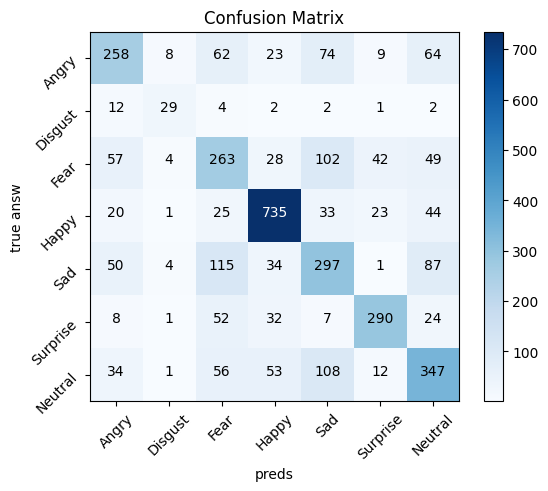

In [125]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(categorical_emotions))
plt.xticks(tick_marks, categorical_emotions, rotation=45)
plt.yticks(tick_marks, categorical_emotions, rotation=45); # ; oculta as infos

thresh = cm.max() / 2.

# itertools.product retorna o produto cartesiano dos parâmetros
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
  # verificação para alterar a cor do número na matriz de confusão
  plt.text(j, i, f"{cm[i, j]}", horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.xlabel('preds')
plt.ylabel('true answ')
plt.savefig('confusion_matrix_mod01.png')

plt.show()

# Testando o modelo

O teste do modelo está no notebook:: **(modelo treinado)Reconhecimento de emoção.ipynb**